In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [4]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [53]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [74]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd*block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))
parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


12297


In [76]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  bnmeani = hpreact - hpreact.mean(0, keepdim=True)
  bnstdi =  hpreact.std(0, keepdim=True)
  hpreact = bngain * bnmeani/bnstdi + bnbias
  
  
  # BatchNorm layer
  # -------------------------------------------------------------
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3054
  10000/ 200000: 1.7978
  20000/ 200000: 1.9030
  30000/ 200000: 2.4623
  40000/ 200000: 2.4436
  50000/ 200000: 1.8843
  60000/ 200000: 2.4164
  70000/ 200000: 2.1734
  80000/ 200000: 1.7217
  90000/ 200000: 2.3225
 100000/ 200000: 2.2514
 110000/ 200000: 2.1481
 120000/ 200000: 1.9692
 130000/ 200000: 1.7992
 140000/ 200000: 2.2786
 150000/ 200000: 2.1926
 160000/ 200000: 1.9286
 170000/ 200000: 2.1592
 180000/ 200000: 2.5601
 190000/ 200000: 1.7961


In [72]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim = True)
    bnstd = hpreact.std(0, keepdim = True)

In [63]:
hpreact.std(0, keepdims=True)

tensor([[2.0942, 2.1422, 2.7741, 3.0816, 1.9655, 2.1977, 2.2061, 2.9444, 1.8390,
         2.4449, 1.9590, 2.2801, 2.0123, 2.2883, 2.6514, 1.9811, 3.2533, 2.5166,
         1.6856, 2.4226, 2.8248, 2.5329, 2.2329, 1.9767, 2.2377, 1.8182, 1.9459,
         1.9742, 1.9859, 2.6081, 1.4443, 2.6056, 1.8801, 2.1452, 1.8693, 2.4193,
         2.6151, 3.5715, 2.5350, 2.2471, 2.2690, 2.9253, 2.3387, 1.8828, 2.0043,
         2.6650, 1.7591, 2.7906, 2.1142, 2.3871, 2.3028, 2.0619, 1.9614, 2.4003,
         2.6282, 2.1319, 2.8230, 2.6815, 2.5190, 2.4156, 1.9214, 2.5489, 1.9027,
         2.0029, 2.4652, 1.7905, 2.1597, 2.9625, 2.1369, 2.7638, 2.7190, 2.0661,
         1.7418, 2.5598, 1.7478, 1.6444, 2.5075, 1.8391, 1.7800, 2.1749, 2.0388,
         2.6767, 1.7793, 2.9159, 2.5929, 2.5268, 1.8192, 2.7817, 1.7324, 2.0085,
         2.1862, 1.5550, 1.8882, 2.8556, 2.0917, 2.2878, 2.3753, 1.9104, 2.1344,
         2.2085, 2.1032, 2.4704, 2.3511, 1.9417, 2.3172, 1.3827, 1.8687, 1.9555,
         1.9820, 2.0921, 2.8

(array([  1.,   1.,   0.,   0.,   3.,   3.,   6.,   9.,  11.,  26.,  27.,
         50.,  55.,  60., 103.,  92., 158., 154., 209., 234., 269., 324.,
        363., 493., 849., 490., 342., 338., 317., 257., 218., 198., 165.,
        132., 111.,  90.,  57.,  50.,  48.,  27.,  19.,  15.,  11.,   5.,
          6.,   1.,   2.,   0.,   0.,   1.]),
 array([-10.06508541,  -9.65366289,  -9.24224037,  -8.83081785,
         -8.41939533,  -8.00797281,  -7.59655029,  -7.18512777,
         -6.77370525,  -6.36228273,  -5.95086021,  -5.53943769,
         -5.12801517,  -4.71659266,  -4.30517014,  -3.89374762,
         -3.4823251 ,  -3.07090258,  -2.65948006,  -2.24805754,
         -1.83663502,  -1.4252125 ,  -1.01378998,  -0.60236746,
         -0.19094494,   0.22047758,   0.6319001 ,   1.04332262,
          1.45474514,   1.86616766,   2.27759018,   2.6890127 ,
          3.10043522,   3.51185774,   3.92328026,   4.33470278,
          4.7461253 ,   5.15754782,   5.56897034,   5.98039286,
          6.391815

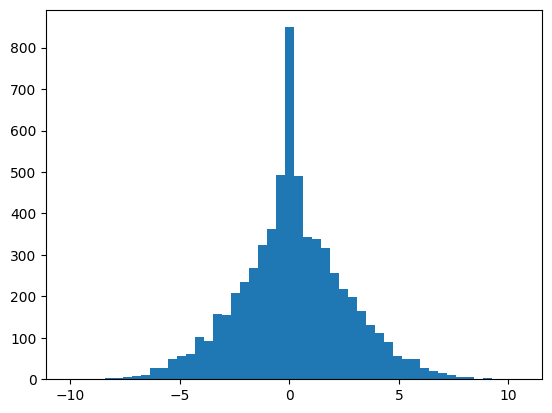

In [59]:
plt.hist(hpreact.view(-1).tolist(), 50)

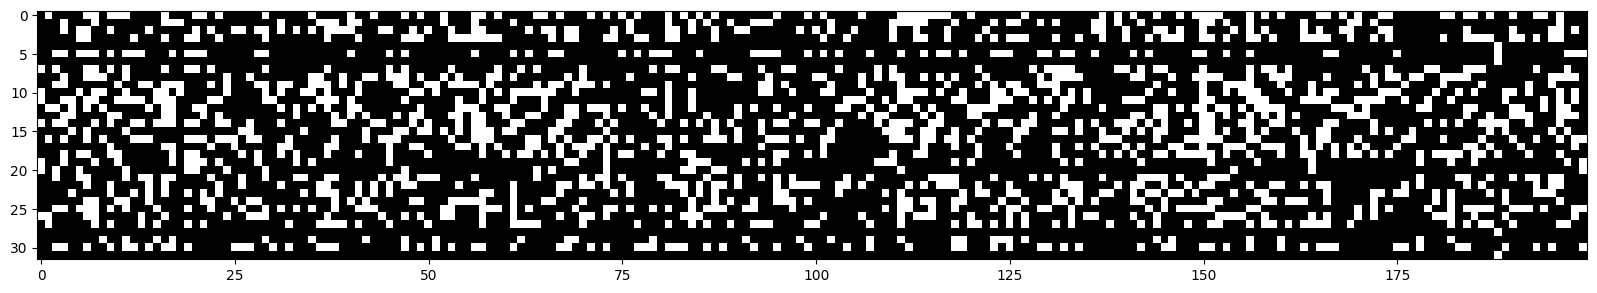

In [60]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

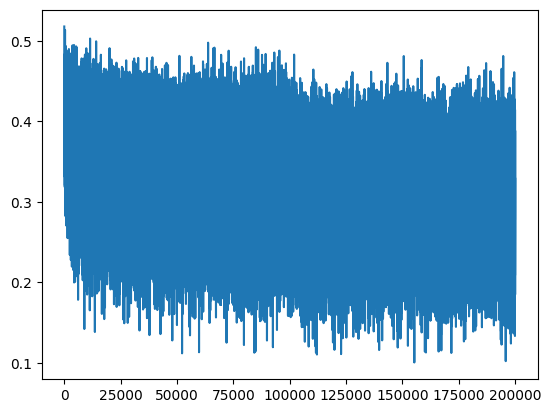

In [61]:
plt.plot(lossi)

In [73]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  # hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0649521350860596
val 2.1251273155212402


In [78]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]


class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True



47024
